In [1]:
from pathlib import Path

import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from shapely.geometry import MultiPoint
import aesara.tensor as at

DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../models")

data = gpd.read_file(DATA_DIR / "spatial_income_1880.gpkg").loc[::2]

xy = pd.DataFrame({"x": data.geometry.x, "y": data.geometry.y})
d = distance_matrix(xy, xy) / 1000
O_norm = (
    StandardScaler()
    .fit_transform(data.orthodox_proportion_ln.values.reshape(-1, 1))
    .flatten()
)

N = data.shape[0]
SEED = 42
N_CLUSTERS = len(data.group.unique())

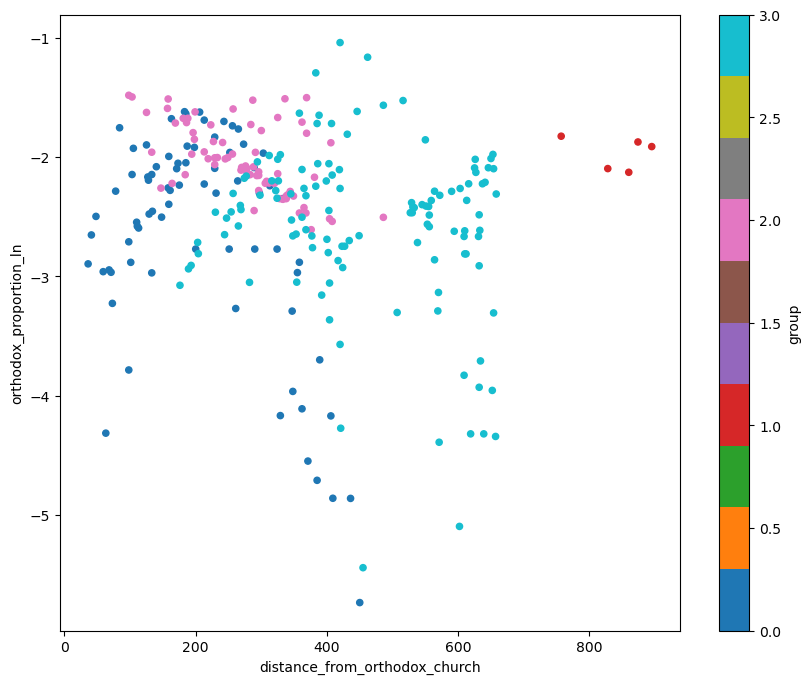

In [2]:
cluster_colors = plt.get_cmap("tab10")
data.plot(
    kind="scatter",
    x="distance_from_orthodox_church",
    y="orthodox_proportion_ln",
    c="group",
    cmap="tab10",
    figsize=(10, 8),
)
plt.show()

In [3]:
data.explore(
    column="group",
    categorical=True,
    cmap=cluster_colors,
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)

In [4]:
data.explore(
    column="total_income_ln",
    cmap="Reds",
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)


In [5]:
data.explore(
    column="orthodox_proportion",
    cmap="Reds",
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)

In [6]:
# with pm.Model() as model_1:
#     idx = data.group
#     W = pm.MutableData("W", data.total_income_ln)

#     θ = pm.Normal("θ", [0, 0], [0.1, 0.1], shape=2)

#     β = pm.MvNormal(
#         "β", mu=θ, cov=np.diagflat(np.array([0.1, 0.1])), shape=(N_CLUSTERS, 2)
#     )
#     μ = at.exp(β[idx, 0] + β[idx, 1] * W)
#     σ = pm.HalfNormal("σ", 0.01)

#     O = pm.Beta("O", mu=μ, sigma=σ, observed=data.orthodox_proportion)

#     prior_1 = pm.sample_prior_predictive()
#     posterior_1 = pm.sample(init="adapt_diag", return_inferencedata=True, target_accept=0.95)
#     posterior_prediction_1 = pm.sample_posterior_predictive(posterior_1)

In [7]:
# graph_1 = pm.model_to_graphviz(model_1)
# graph_1

In [8]:
# az.plot_posterior(posterior_1, grid=(N_CLUSTERS + 2, 2))
# plt.show()

In [9]:
# az.plot_trace(posterior_1)
# plt.show()

In [10]:
# az.plot_forest(posterior_1, combined=True, hdi_prob=0.94)
# plt.show()

In [11]:
# az.plot_ppc(posterior_prediction_1)
# plt.show()

# Model

Heavier spatial error model

$$ O_i \sim N(\mu_i, \sigma) $$
$$ \sigma \sim Exponential(10) $$
$$ \mu_i = \beta_{k[i],0} + \beta_{k[i],1} W + \beta_{k[i],2} C + \gamma_i $$
$$ \beta_k \sim MvNormal \left( \theta, \begin{bmatrix} 0.1 & 0 & 0 \\ 0 & 0.1 & 0 \\ 0 & 0 & 0.1 \end{bmatrix} \right) $$
$$ \theta \sim MvNormal \left( \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.1 & 0 & 0 \\ 0 & 0.1 & 0 \\ 0 & 0 & 0.1 \end{bmatrix} \right) $$
$$ \gamma \sim MvNormal \left( \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}_{(i)}, \bold K \right) $$
$$ \bold K = \eta^2 exp \left( -\rho^2 D^2 \right) + 0.01 \bold I_{(i)} $$
$$ \eta^2 \sim N(1, 0.1) $$
$$ \rho^2 \sim N(20, 5) $$

In [12]:
with pm.Model() as model_2:
    idx = data.group
    W = pm.MutableData("W", data.total_income_ln)
    C = pm.MutableData("C", data.distance_from_orthodox_church) / 1000

    θ = pm.Normal("θ", [0, 0, 0], [0.1, 0.1, 0.1], shape=3)
    β = pm.MvNormal(
        "β", mu=θ, cov=np.diagflat(np.array([0.1, 0.1, 0.1])), shape=(N_CLUSTERS, 3)
    )

    η2 = pm.Normal("η²", 1, 0.1)
    ρ2 = pm.Normal("ρ²", 20, 5)
    K = η2 * at.exp(-ρ2 * at.power(d, 2)) + np.diag([0.01] * N)
    γ = pm.MvNormal("γ", mu=np.zeros(N), cov=K, shape=N)

    μ = β[idx, 0] + β[idx, 1] * W + β[idx, 2] * C + γ
    σ = pm.Exponential("σ", 10)
    O = pm.Normal("O", mu=μ, sigma=σ, observed=O_norm)

    prior_predictive = pm.sample_prior_predictive(samples=100, random_seed=SEED)
    idata = pm.sample(
        draws=1000,
        tune=1000,
        init="adapt_diag",
        return_inferencedata=True,
        target_accept=0.95,
        random_seed=SEED,
    )
    posterior_predictive = pm.sample_posterior_predictive(
        idata,
        random_seed=SEED,
    )

Sampling: [O, β, θ, σ]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 302 seconds.
Sampling: [O]


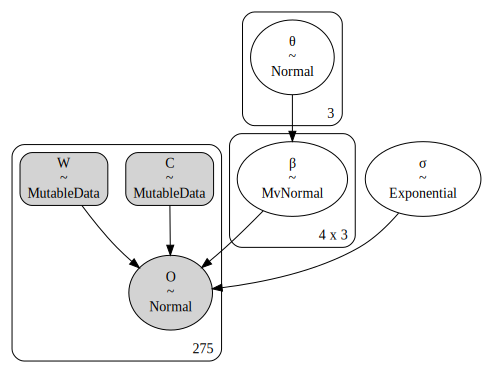

In [13]:
graph_2 = pm.model_to_graphviz(model_2)
graph_2

KeyError: 'η²'

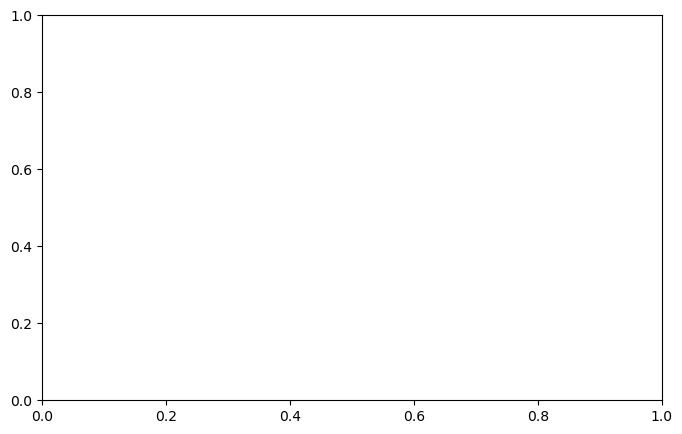

In [14]:
# Prior sanity check
_, ax = plt.subplots(1, 1, figsize=(8, 5))
cov = prior_predictive['prior']
x = np.linspace(0, 1, 100)
median_cov = (np.median(cov["η²"][0].values) * at.exp(-np.median(cov["ρ²"][0].values) * (x**2))).eval()

ax.plot(
    x,
    (cov["η²"][0, ::2].values[:, None] * np.exp(-cov["ρ²"][0, ::2].values[:, None] * (x**2))).T,
    "k",
    alpha=0.1,
)
ax.plot(x, median_cov, lw=1)

ax.set(
    title="prior",
    # ylim=(-0.1, 2),
    xlabel="distance, km",
    ylabel="covariance",
);

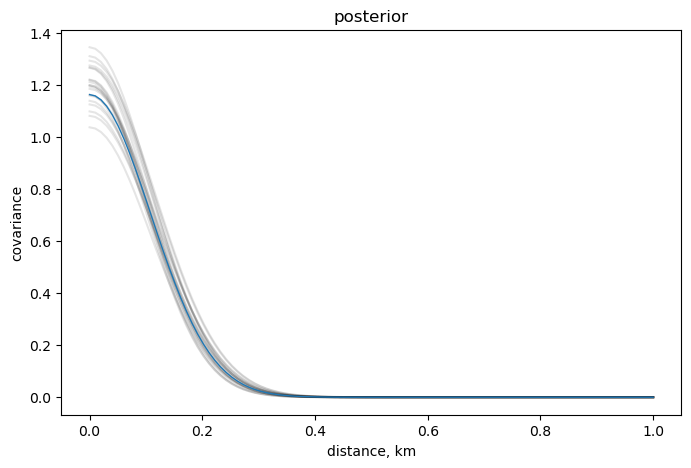

In [ ]:
# Posterior sanity check
_, ax = plt.subplots(1, 1, figsize=(8, 5))
cov = idata['posterior']
x = np.linspace(0, 1, 100)
median_cov = (np.median(cov["η²"][0].values) * at.exp(-np.median(cov["ρ²"][0].values) * (x**2))).eval()

ax.plot(
    x,
    (cov["η²"][0, ::50].values[:, None] * np.exp(-cov["ρ²"][0, ::50].values[:, None] * (x**2))).T,
    "k",
    alpha=0.1,
)
ax.plot(x, median_cov, lw=1)

ax.set(
    title="posterior",
    # ylim=(-0.1, 2),
    xlabel="distance, km",
    ylabel="covariance",
);

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['γ'] have not been found and will be ignored
  warnings.warn(


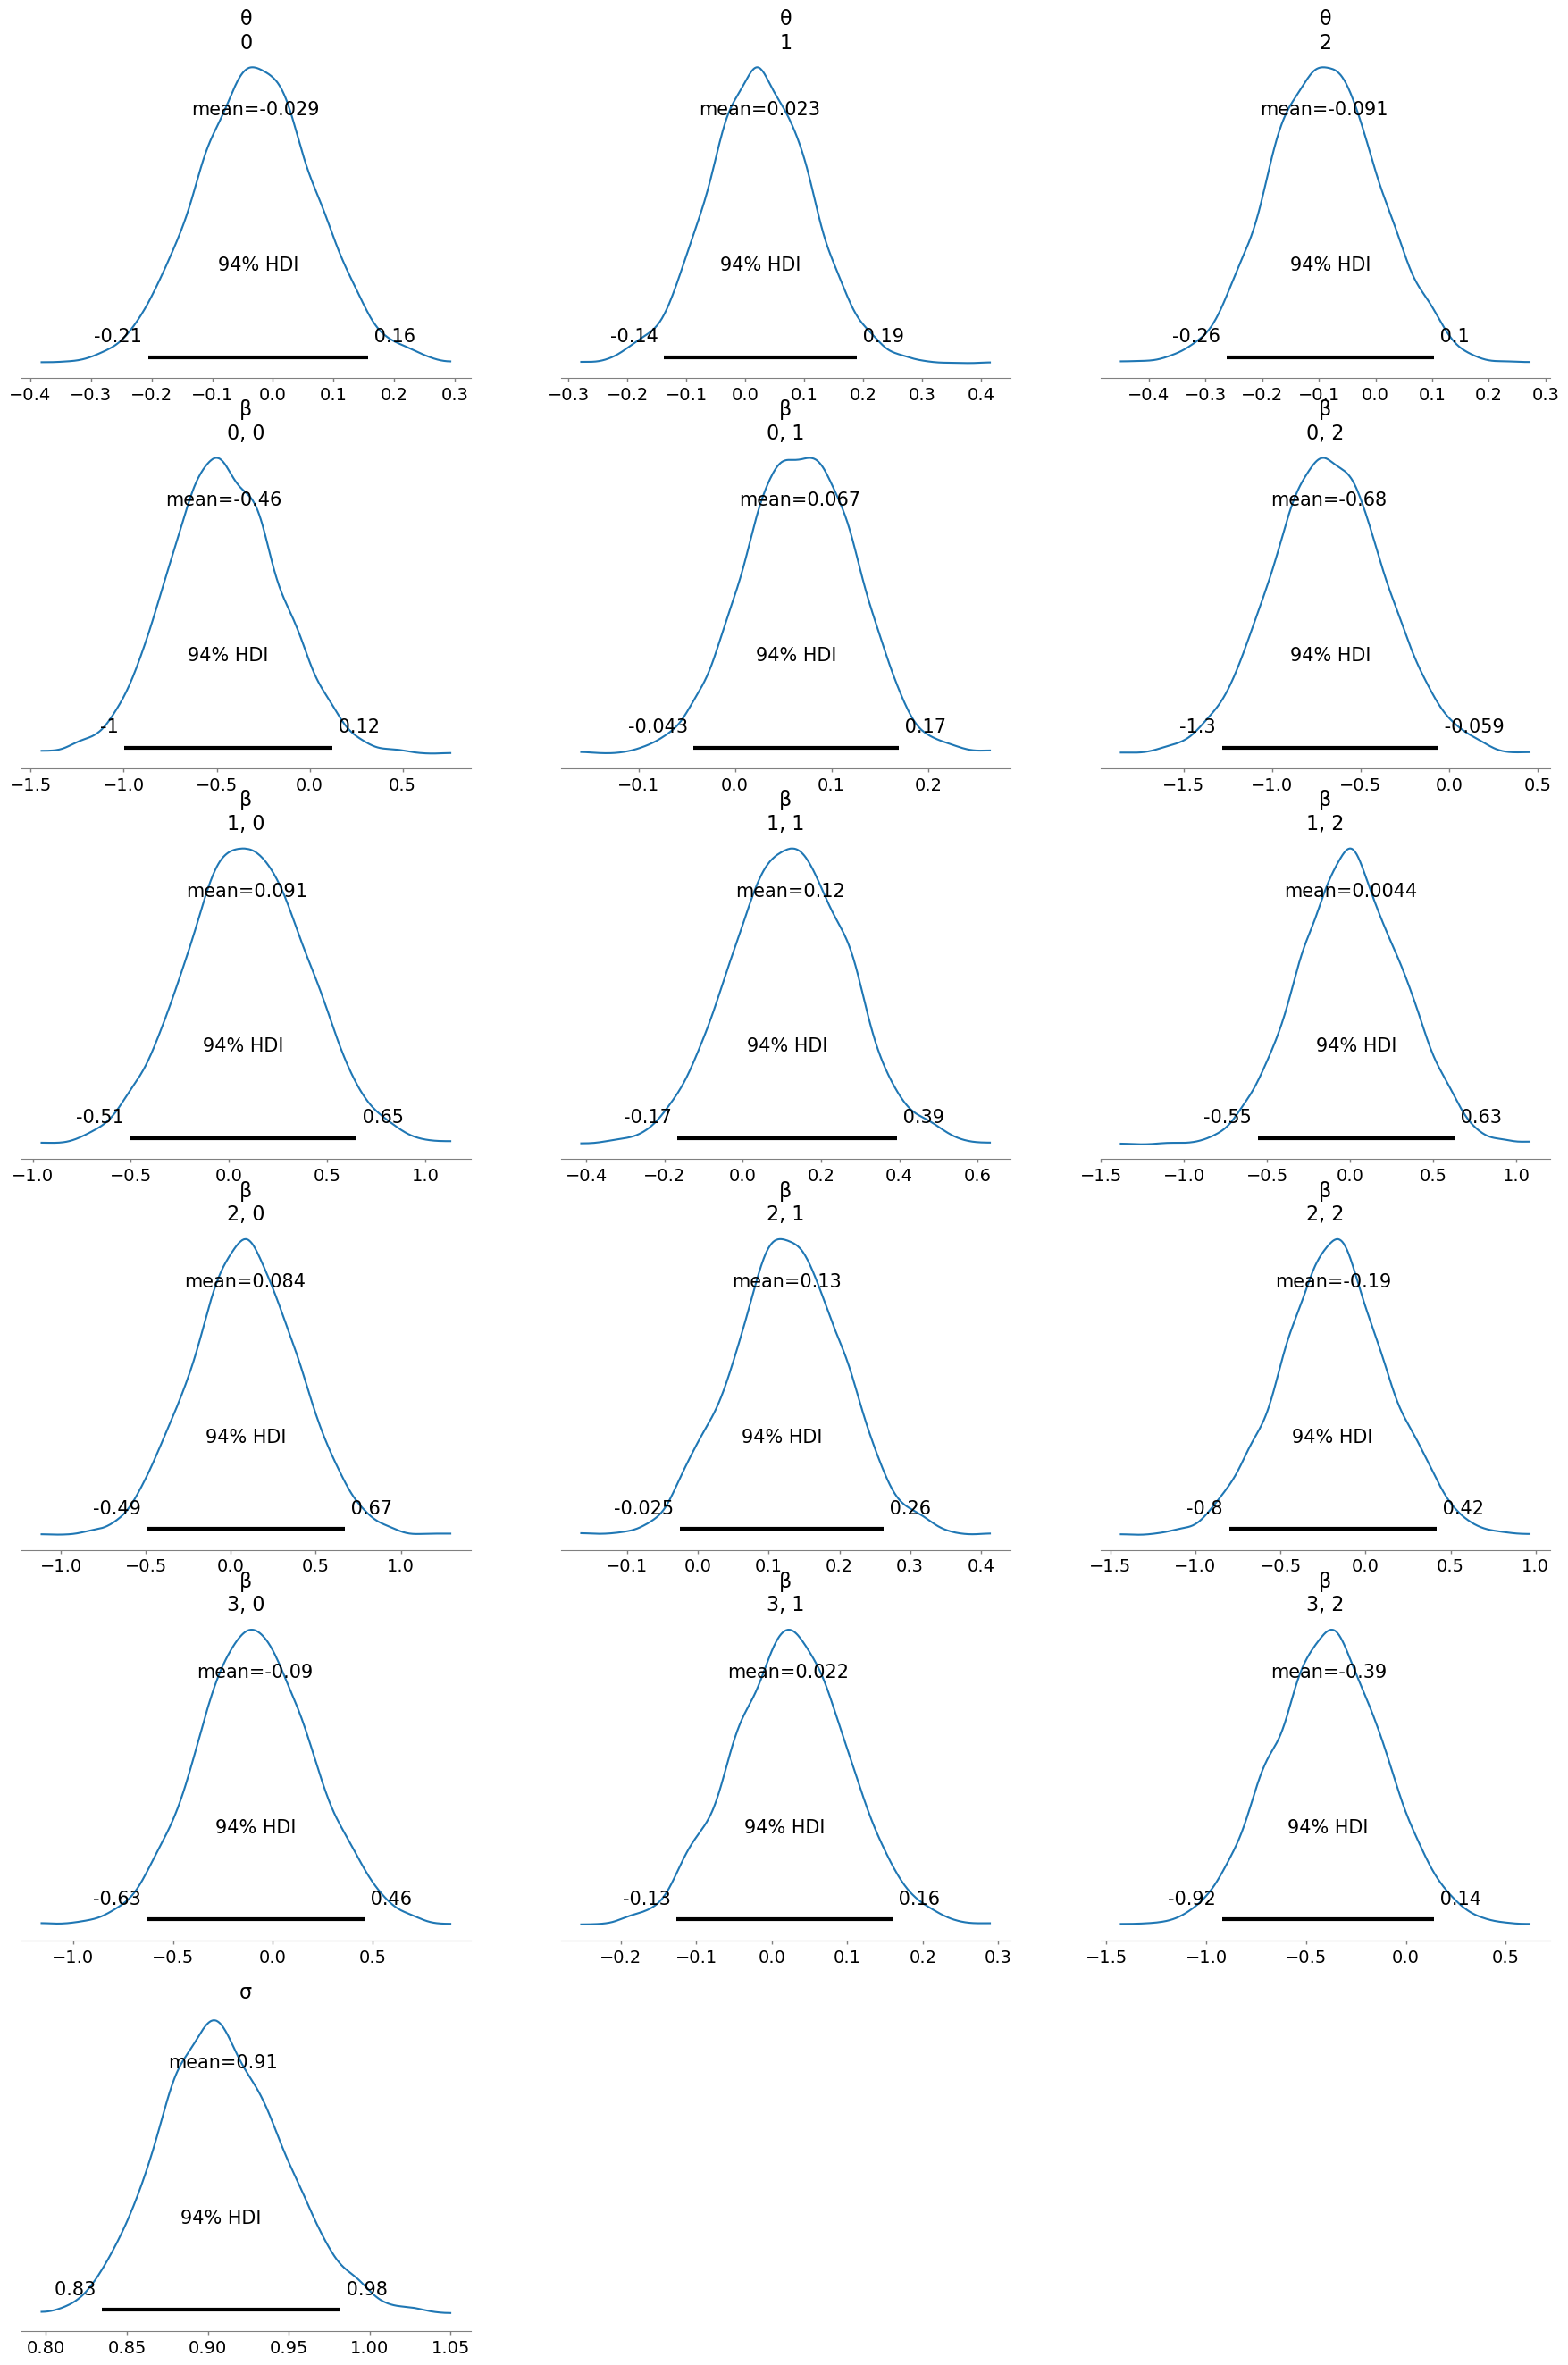

In [15]:
az.plot_posterior(idata, var_names=["~γ"], grid=[N_CLUSTERS + 2, 3])
plt.show()

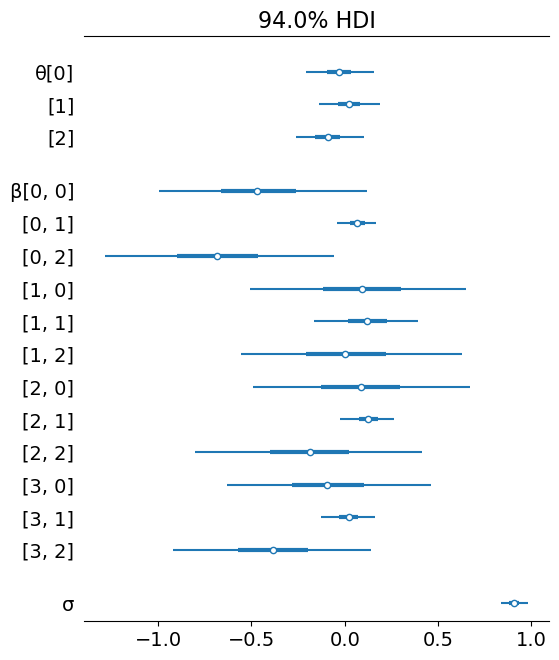

In [16]:
az.plot_forest(idata, combined=True, hdi_prob=0.94, var_names=["~γ"])
plt.show()

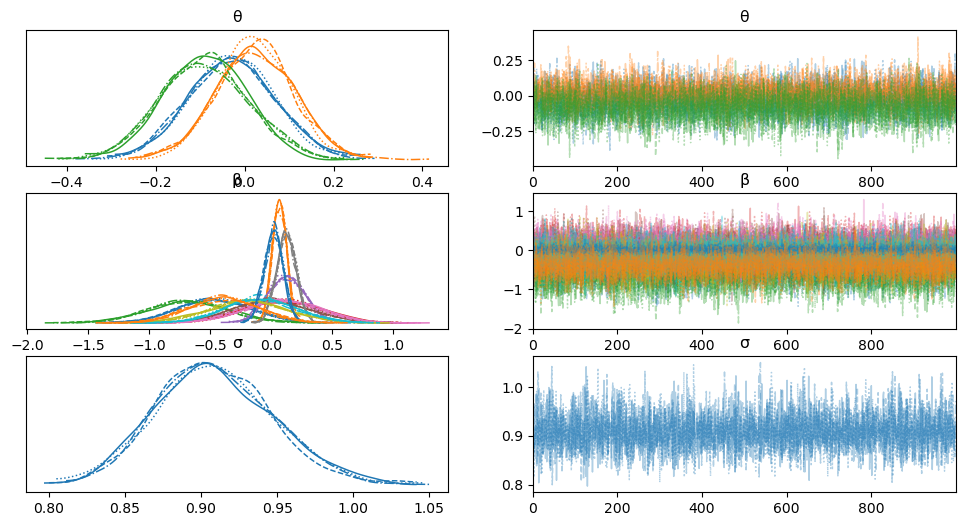

In [17]:
az.plot_trace(idata)
plt.show()

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


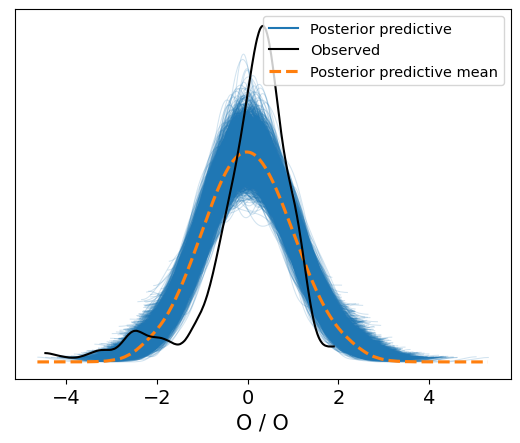

In [18]:
az.plot_ppc(posterior_predictive)
plt.show()